# Prophet
### 04.05.2021

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from fbprophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()

Saving tsdata1.xlsx to tsdata1.xlsx


## SARIMAX

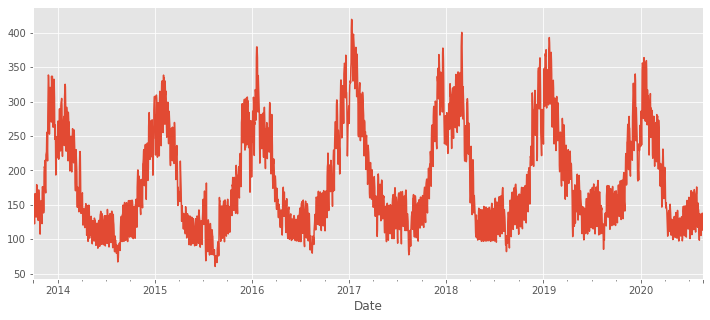

In [10]:
data = pd.read_excel('tsdata1.xlsx', index_col='Date', parse_dates=True)
data.index = pd.DatetimeIndex(data.index, freq='D')
# data.columns = ['TGE']
data.head(4)

data['IT'].plot(figsize=(12,5))
plt.show()

In [17]:
data.head()

,IT,EXOG1,EXOG2,IT_box,IT_box_sdiff
Date,,,,,
2013-10-01,151.996076,17.54,11.20,3.793114,NaN
2013-10-02,148.865675,17.39,11.07,3.781576,NaN
2013-10-03,155.963230,16.16,12.73,3.807360,NaN
2013-10-04,164.411660,16.22,10.53,3.836393,NaN
2013-10-05,131.043380,16.04,10.88,3.710258,NaN


In [136]:
data['const'] = 1
data.head()

,IT,EXOG1,EXOG2,IT_box,IT_box_sdiff,model,const
Date,,,,,,,
2013-10-01,151.996076,17.54,11.20,3.793114,NaN,0.768428,1
2013-10-02,148.865675,17.39,11.07,3.781576,NaN,0.770145,1
2013-10-03,155.963230,16.16,12.73,3.807360,NaN,0.783501,1
2013-10-04,164.411660,16.22,10.53,3.836393,NaN,0.783535,1
2013-10-05,131.043380,16.04,10.88,3.710258,NaN,0.785476,1


Оптимальный параметр преобразования Бокса-Кокса: -0.117648
Критерий Дики-Фуллера: p=0.011608


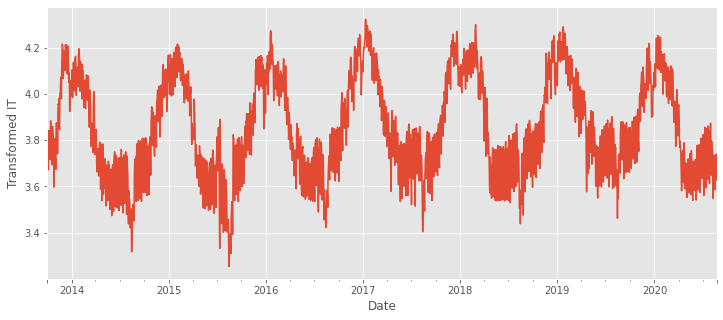

In [137]:
# data['TGE'] = data['TGE'] 
data['IT_box'], lmbda = boxcox(data['IT'])
data['IT_box'].plot(figsize=(12,5))
plt.ylabel('Transformed IT')
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(data['IT_box'])[1])

Критерий Дики-Фуллера: p=0.000000


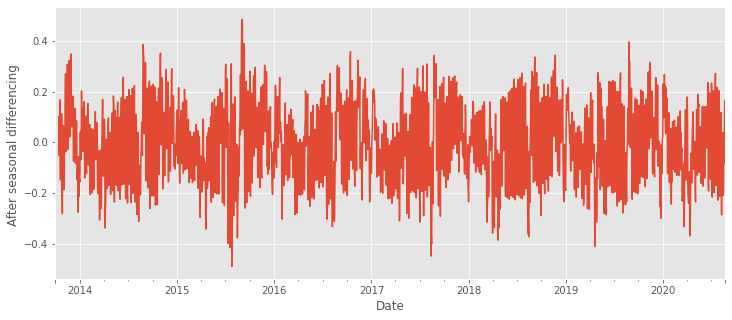

In [138]:
data['IT_box_sdiff'] = data['IT_box'].diff(12)
data['IT_box_sdiff'].plot(figsize=(12,5))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(data['IT_box_sdiff'].dropna())[1])

In [140]:
model = SARIMAX(data['IT_box'][:-14],
                        order=(2, 0, 1), 
                        seasonal_order=(1, 1, 1, 12), exog=data[['EXOG1', 'EXOG2','const']][:-14]).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



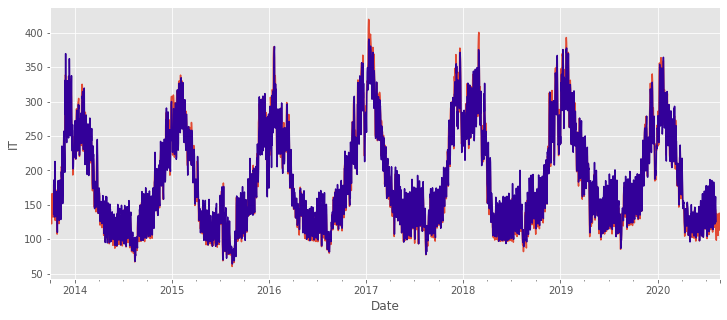

In [141]:
data['model'] = inv_boxcox(model.fittedvalues, lmbda)
data['IT'].plot(figsize=(12,5))
data.model[13:].plot(color='#330099')
plt.ylabel('IT')
plt.show()

In [142]:
# start = data.index[:-14] + pd.DateOffset(days=14)
start = data.index[-14]
end = start + pd.DateOffset(days=14)

In [145]:
sarimax_pr = inv_boxcox(model.predict(start=start, end=end, exog=data[['EXOG1', 'EXOG2', 'const']][-15:]), lmbda)

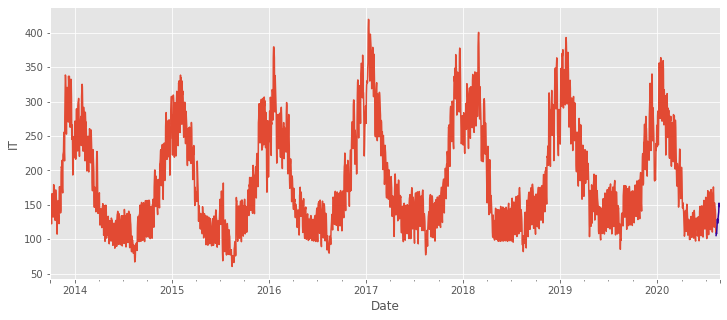

In [147]:
data['IT'][:-14].plot(figsize=(12,5))
inv_boxcox(model.predict(start=start, end=end, exog=data[['EXOG1', 'EXOG2', 'const']][-15:]), lmbda).plot(color='#330099')
plt.ylabel('IT')
plt.show()

## Prophet

In [94]:
data_prophet = data[['IT']][:-14]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
data_prophet.head()

,ds,y
0,2013-10-01,151.996076
1,2013-10-02,148.865675
2,2013-10-03,155.963230
3,2013-10-04,164.411660
4,2013-10-05,131.043380


In [95]:
data_prophet['exog1'] = data['EXOG1'].values[:-14]
data_prophet['exog2'] = data['EXOG2'].values[:-14]

In [96]:
data_prophet.tail()

,ds,y,exog1,exog2
2499,2020-08-04,148.711888,20.87,12.31
2500,2020-08-05,143.210092,18.67,10.71
2501,2020-08-06,143.026280,18.42,8.58
2502,2020-08-07,135.719044,20.23,7.73
2503,2020-08-08,110.035668,21.22,7.54


In [120]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=5)
model.add_regressor('exog1')
model.add_regressor('exog2')
model.fit(data_prophet)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


In [121]:
future = model.make_future_dataframe(periods=14, freq='D')
future['exog1'] = data['EXOG1'].values
future['exog2'] = data['EXOG2'].values

In [122]:
forecast = model.predict(future)

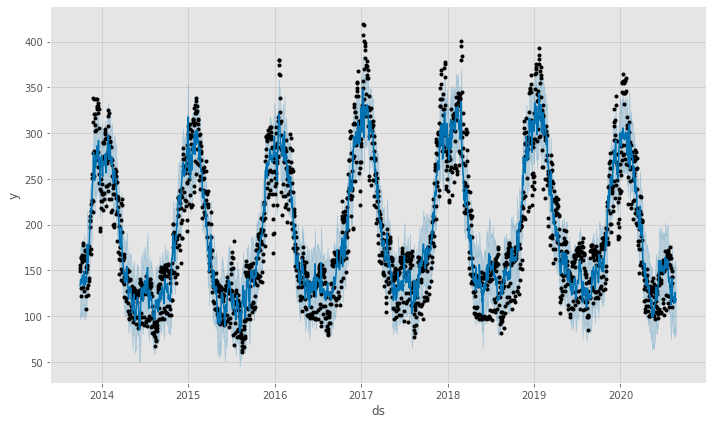

In [123]:
model.plot(forecast)
plt.show()

In [124]:
from sklearn.metrics import mean_squared_error

In [148]:
mean_squared_error(sarimax_pr.values, data['IT'][-15:])

302.58015249938916

In [135]:
mean_squared_error(forecast['yhat'].values[-15:], data['IT'][-15:])

199.22057029367335